# Classification: Initial tinkering with E. coli iModulon data to see if we can train a CNN to classify promoters into iModulons

In [1]:
import pandas as pd
import numpy as np
import utils as u
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats


import altair as alt
import seaborn as sns
import torch_utils as tu

import torch

import random
random.seed(46)

In [2]:
import utils as u 
import torch_utils as tu
import models as m

from sklearn.metrics import r2_score

from skorch import NeuralNetRegressor,NeuralNetClassifier
from skorch.callbacks import EarlyStopping,Checkpoint,GradientNormClipping
from skorch.dataset import Dataset
from skorch.helper import predefined_split


## Load data

In [3]:
fname = 'ec_iMod_out/ecoli_seq_M_opFilt.tsv' 
XY = pd.read_csv(fname,sep='\t')
print(XY.shape)
display(XY.head())

loc2seq = dict([(x,z) for (x,z) in XY[['locus_tag','upstream_region']].values])

print(loc2seq['b3575'])

(2129, 99)


,locus_tag,gene,product,type,strand,start,upstream_region,0,1,2,...,82,83,84,85,86,87,88,89,90,91
0,b0005,yaaX,DUF2502 domain-containing protein YaaX,CDS,1,5233,GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...,0.008229,-0.000685,-0.005215,...,-0.006856,0.010676,0.008874,0.018497,0.000700,-0.013267,0.015265,0.016886,-0.015319,-0.020727
1,b0007,yaaJ,putative transporter YaaJ,CDS,-1,6528,AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...,0.008111,-0.003929,0.003207,...,-0.000337,-0.010468,0.016122,0.010361,-0.003899,-0.022839,-0.003665,-0.001823,-0.023604,-0.012765
2,b0008,talB,transaldolase B,CDS,1,8237,ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...,0.008629,-0.001270,-0.005664,...,0.000394,0.007215,-0.000707,-0.012959,-0.002329,0.006391,-0.003650,-0.008537,0.002898,-0.000891
3,b0009,mog,molybdopterin adenylyltransferase,CDS,1,9305,AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...,0.002952,0.002053,-0.002882,...,-0.009291,-0.000226,0.016013,0.002179,0.004891,-0.002365,-0.003490,-0.006066,-0.011982,0.011477
4,b0010,satP,acetate/succinate:H(+) symporter,CDS,-1,9927,CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...,0.006142,0.000884,0.008166,...,-0.009214,-0.010588,0.001363,0.003979,-0.005208,0.003190,-0.015137,-0.005784,-0.001302,0.010800


TCAATCAGCATCAACCCGCGAAACAGACTCTGGCTTCCGGCTGGACGCTCTTTTTCCTGCGCCATCTCGTTCTCTTTTTTTCCCATCACTTCTTTCCCCATTTTGTCGCGTCCTGATGGTAGCGCAAAGTGTGCCGTAGTTCACGATCTCGACAGATAATTTATAACCAATTGATTTTTATGTCTTTTGAAATTCATCAATCAGATTGCCTTGTTAAAAAGTGATCGATATATTTGAAATCAAGTTTCGCATATTGAAATTTTAAGCCAAAAAAGCGATCAAAAAAACAAGGAAGCCTGG


In [4]:
# get iModulon column labels
M = pd.read_csv('ec_iMod_out/iMod_download/M.csv',index_col=0)
imods = [x.strip() for x in M.columns]
imods[:5]

['0', '1', '2', '3', '4']

In [5]:
# load binarized version of M matrix
Mb = pd.read_csv('ec_iMod_out/iMod_download/gene_presence_matrix.csv',index_col=0).astype(int)
Mb.index.name='locus_tag'
Mb

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
locus_tag,,,,,,,,,,,,,,,,,,,,,
b0002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b0003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b0004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b0005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b0006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4688,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b4693,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b4696_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Convert XY into binarazed version
XYb = pd.merge(XY.drop(imods,axis=1), Mb.reset_index(),on='locus_tag')
XYb

,locus_tag,gene,product,type,strand,start,upstream_region,0,1,2,...,82,83,84,85,86,87,88,89,90,91
0,b0005,yaaX,DUF2502 domain-containing protein YaaX,CDS,1,5233,GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,b0007,yaaJ,putative transporter YaaJ,CDS,-1,6528,AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,b0008,talB,transaldolase B,CDS,1,8237,ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,b0009,mog,molybdopterin adenylyltransferase,CDS,1,9305,AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,b0010,satP,acetate/succinate:H(+) symporter,CDS,-1,9927,CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,b4395,ytjC,putative phosphatase,CDS,1,4633796,TGCTGTCACCATCGATGCCAGCTTCAATCGCCACCCAAAAATCAGC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2125,b4396,rob,DNA-binding transcriptional dual regulator Rob,CDS,-1,4634440,ATACGGTGTCGACCGAACCAATCTCTTCTGCATGAGCCAATGGCCC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2126,b4397,creA,PF05981 family protein CreA,CDS,1,4635520,CTTTCGCCGCTACATTGTCGAGCGACAGGGGCTGATCCAGATGACC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2127,b4401,arcA,DNA-binding transcriptional dual regulator ArcA,CDS,-1,4639589,ACAATTGAACTTGATATATGTCAACGAAGCGTAGTTTTATTGGGTG...,0,0,0,...,0,0,0,0,0,0,0,0,0,0


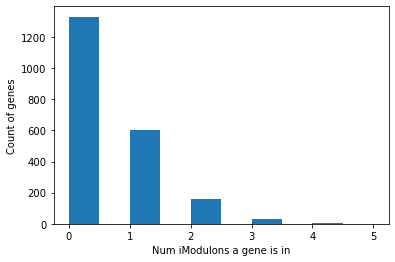

In [7]:
# distribution of ecoli genes and how many iMods they are in
plt.hist([sum(XYb.iloc[i][imods]) for i in range(XYb.shape[0])])
plt.xlabel("Num iModulons a gene is in")
plt.ylabel("Count of genes")
plt.show()

## Filter out uninformative iModulons (and genes?)
* Some iModulons have too few genes to learn from. Get rid of any less than 5. (after filtering out for genes in operons)
* Some genes aren't in any iModulons. Are those worth excluding too?

In [8]:
# make a list of imodulons above a certain threshold
thresh = 4
#mbc = dict([(Mb.iloc[i].name,sum(Mb.iloc[i])) for i in range(Mb.shape[0])])
XYim = XYb[imods]
mbc = dict([(XYim.T.iloc[i].name,sum(XYim.T.iloc[i])) for i in range(XYim.shape[1])])
imods_filt = [x for x in mbc if mbc[x]>thresh]
print("num iMods that pass:",len(imods_filt))

num iMods that pass: 58


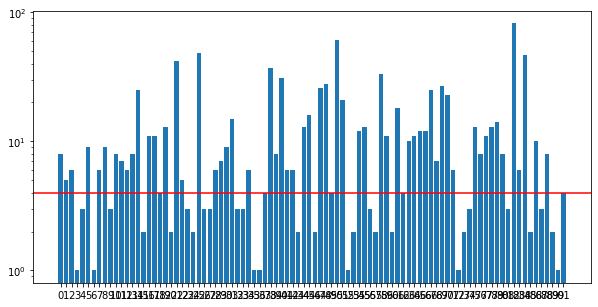

In [9]:
figure = plt.figure(figsize=(10,5))
plt.bar(imods,[mbc[x] for x in imods])
plt.axhline(thresh,c='r')
plt.yscale("log")

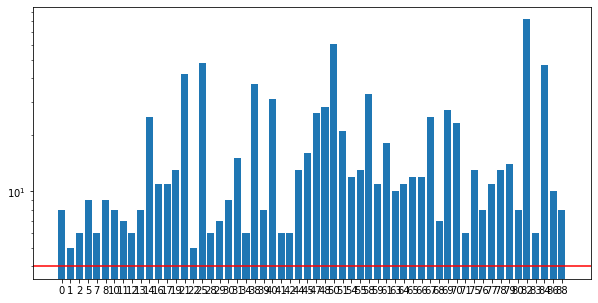

In [10]:
figure = plt.figure(figsize=(10,5))
plt.bar(imods_filt,[mbc[x] for x in imods_filt])
plt.axhline(thresh,c='r')
plt.yscale("log")


In [11]:
# these iMods seem too small to meaningfully try to predict
# (some are single-gene iMods)
imods_exclude = [x for x in mbc if mbc[x]<=thresh]
print(f"num iMods filtered out b/c fewer than {thresh} genes: {len(imods_exclude)}")

num iMods filtered out b/c fewer than 4 genes: 34


In [12]:
# drop excluded iMods and keep binary labels
XY = XYb.drop(imods_exclude,axis=1)
XY

,locus_tag,gene,product,type,strand,start,upstream_region,0,1,2,...,76,77,78,79,80,82,83,84,86,88
0,b0005,yaaX,DUF2502 domain-containing protein YaaX,CDS,1,5233,GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,b0007,yaaJ,putative transporter YaaJ,CDS,-1,6528,AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,b0008,talB,transaldolase B,CDS,1,8237,ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,b0009,mog,molybdopterin adenylyltransferase,CDS,1,9305,AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,b0010,satP,acetate/succinate:H(+) symporter,CDS,-1,9927,CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,b4395,ytjC,putative phosphatase,CDS,1,4633796,TGCTGTCACCATCGATGCCAGCTTCAATCGCCACCCAAAAATCAGC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2125,b4396,rob,DNA-binding transcriptional dual regulator Rob,CDS,-1,4634440,ATACGGTGTCGACCGAACCAATCTCTTCTGCATGAGCCAATGGCCC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2126,b4397,creA,PF05981 family protein CreA,CDS,1,4635520,CTTTCGCCGCTACATTGTCGAGCGACAGGGGCTGATCCAGATGACC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2127,b4401,arcA,DNA-binding transcriptional dual regulator ArcA,CDS,-1,4639589,ACAATTGAACTTGATATATGTCAACGAAGCGTAGTTTTATTGGGTG...,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## splitting

In [13]:
# Split data into train/test/split here and now
full_train_df,test_df = tu.quick_split(XY)
train_df, val_df = tu.quick_split(full_train_df)

print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)


# # coi1 = ['0','1','2','3','4']
# # coi2 = ['5','6','7','8','9']
# # coi3 = ['10','11','12','13','14']
# coi1 = imods_filt[:10]
# assert(train_df.shape[0] + val_df.shape[0] == full_train_df.shape[0])
# view_train_test_dist(train_df, test_df,coi1,"M-matrix weights",val_df=val_df)
# # view_train_test_dist(train_df, test_df,coi2,"M-matrix weights",val_df=val_df)
# # view_train_test_dist(train_df, test_df,coi3,"M-matrix weights",val_df=val_df)

# view_train_test_dist(full_train_df, test_df,coi1,"M-matrix weights")


(1703, 66)
(426, 66)
(1362, 67)
(341, 67)


## convert to skorch-able dfs

In [14]:
def make_mt_skorch_dfs(df,seq_col='seq',target_cols=['highCu','noCu']):
    '''
    Make multi-task X,y matrix,vec for skorch fit() loop.
    '''
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    # number of labels = len(target_cols)
    labels = torch.tensor(list(df[target_cols].values))
    # bad dimension? fixed in model.forward for now
    
    return ohe_seqs.float(), labels.float()

In [15]:
X, y = make_mt_skorch_dfs(XY, seq_col="upstream_region",target_cols=imods_filt)
print("\nX:",X.shape)
print("y:",y.shape)

Xtrain, ytrain = make_mt_skorch_dfs(train_df, seq_col="upstream_region",target_cols=imods_filt)
print("\nXtrain:",Xtrain.shape)
print("ytrain:",ytrain.shape)

Xval, yval = make_mt_skorch_dfs(val_df, seq_col="upstream_region",target_cols=imods_filt)
print("\nXval:",Xval.shape)
print("yval:",yval.shape)

Xtest, ytest = make_mt_skorch_dfs(test_df, seq_col="upstream_region",target_cols=imods_filt)
print("\nXtest:",Xtest.shape)
print("ytest:",ytest.shape)

Xfull_train, yfull_train = make_mt_skorch_dfs(full_train_df, seq_col="upstream_region",target_cols=imods_filt)
print("\nXfull_train:",Xfull_train.shape)
print("yfull_train:",yfull_train.shape)


X: torch.Size([2129, 300, 4])
y: torch.Size([2129, 58])

Xtrain: torch.Size([1362, 300, 4])
ytrain: torch.Size([1362, 58])

Xval: torch.Size([341, 300, 4])
yval: torch.Size([341, 58])

Xtest: torch.Size([426, 300, 4])
ytest: torch.Size([426, 58])

Xfull_train: torch.Size([1703, 300, 4])
yfull_train: torch.Size([1703, 58])


In [16]:
def count_imod_train_test_labels(imods,ytr,yte):
    '''
    Given a train and test set of y labels, count how many trues
    are in each imodulon for each split
    '''
    # loop through each train example and count True labels for each imodulon
    imc_train = torch.tensor([0 for x in range(ytr.shape[1])])
    for s in ytr:
        imc_train += s.long()

    # loop through each test example and count True labels for each imodulon
    imc_test = torch.tensor([0 for x in range(yte.shape[1])])
    for s in yte:
        imc_test += s.long()
    
    # print warning for missing examples
    for i,im in enumerate(imods):
        if imc_train[i] == 0:
            print(f"WARNING: iMod {im} train set missing True example.")
        if imc_test[i] == 0:
            print(f"WARNING: iMod {im} test set missing True example.")
            
    # make sure the len of these imod vectors is the same
    assert len(imc_train) == len(imc_test) == len(imods)

    # stack into a pandas df, melt it, plot it
    ts = np.array(torch.stack((torch.tensor([int(x) for x in imods]), imc_train, imc_test)).T)
    imc_df = pd.DataFrame(data=ts,columns=['imod','train_count','test_count'])
    imc_df_melt = imc_df.melt(id_vars=['imod'],value_vars=['train_count','test_count'],var_name='split',value_name='count')
    
    # plot stuff
    plt.figure(figsize=(20,5))
    sns.barplot(data=imc_df_melt, x='imod', y='count', hue='split')
    #plt.yscale('log')
    
    #return imc_df_melt

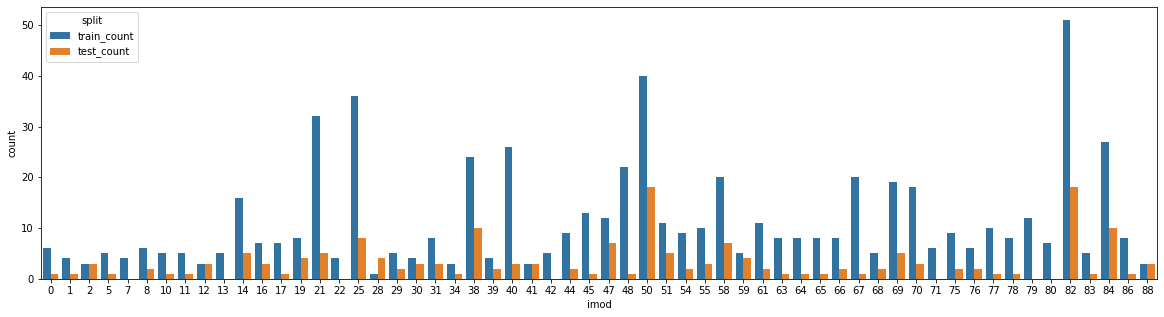

In [17]:
count_imod_train_test_labels(imods_filt,ytrain,ytest)

### try splitting with sci-kit multilearn to stratify classes?

In [18]:
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

In [19]:
print("\nX:",X.shape)
print("y:",y.shape)


X: torch.Size([2129, 300, 4])
y: torch.Size([2129, 58])


In [20]:
Xfull_train_strat, yfull_train_strat, Xtest_strat, ytest_strat = iterative_train_test_split(X, y, test_size = 0.2)


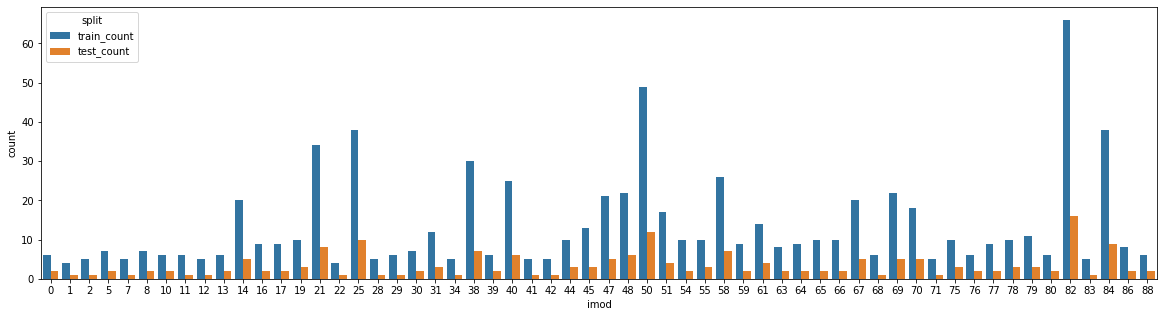

In [21]:
count_imod_train_test_labels(imods_filt,yfull_train_strat,ytest_strat)

Note: The stratified split doesn't having any iMods missing true examples!

## pick some params

In [22]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [23]:
from skorch import NeuralNet
import torch.nn as nn
from skorch.dataset import ValidSplit

In [24]:
# apparently i think DNA_2CNN_2FC_Multi should still work for multi-label classification

net_randsplit = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    criterion=torch.nn.BCEWithLogitsLoss(),
    train_split=ValidSplit(0.2), # stratified =True
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=ytrain.shape[1],
    module__num_filters1=128,
    module__num_filters2=64,
    module__kernel_size1=8,
    module__kernel_size2=8,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=2000,
    lr=0.01,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=100),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.Adam,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

In [25]:
net_randsplit.fit(Xfull_train, yfull_train)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5838       0.0059        0.1733  1.4851
      2        0.1077       0.6334        0.0914  0.1091
      3        0.0606       0.6334        0.0545  0.1043
      4        0.0478       0.6334        0.0492  0.0845
      5        0.0450       0.6334        0.0479  0.0835
      6        0.0440       0.6334        0.0470  0.0821
      7        0.0434       0.6334        0.0470  0.0807
      8        0.0433       0.6334        0.0469  0.0807
      9        0.0434       0.6334        0.0469  0.0812
     10        0.0434       0.6334        0.0467  0.0818
     11        0.0433       0.6334        0.0468  0.0819
     12        0.0432       0.6334        0.0467  0.0816
     13        0.0432       0.6334        0.0471  0.0813
     14        0.0431       0.6334        0.0468  0.0820
     15        0.0431       0.6334        0.0467  0.0811
     16        0.0432       0.6

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 64, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=5760, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=58, bias=True)
    )
  ),
)

# Viz model results

In [26]:
def sk_loss_plot(nets,yscaler=5):
    '''
    Draw the train/val losses from a skorch net
    '''
    
    fig = plt.figure(figsize=(10,5))
    smallest_val = 999
    for i,(net,name) in enumerate(nets):
        # plot net_regr's loss trace
        train_loss = net.history[:, 'train_loss']
        valid_loss = net.history[:, 'valid_loss']
        
        plt.plot(train_loss,'-',color=f"C{i}", label=f"{name} Train",linewidth=1.0,alpha=0.5)
        plt.plot(valid_loss,'-',color=f"C{i}", label=f"{name} Val",linewidth=3.0,alpha=0.5)
        
        val_min_ep,val_min = min(enumerate(valid_loss),key = lambda t: t[1])
        plt.axhline(val_min,linestyle='--',c=f"C{i}",linewidth=0.5)
        plt.axvline(val_min_ep,linestyle='--',c=f"C{i}",linewidth=0.5)
        #plt.axhline(5,c='k')
        
        if val_min < smallest_val:
            smallest_val = val_min

    plt.ylim(0,smallest_val*yscaler)
    plt.xlabel("Epoch",fontsize=14)
    plt.ylabel("MSE Loss",fontsize=14)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
    

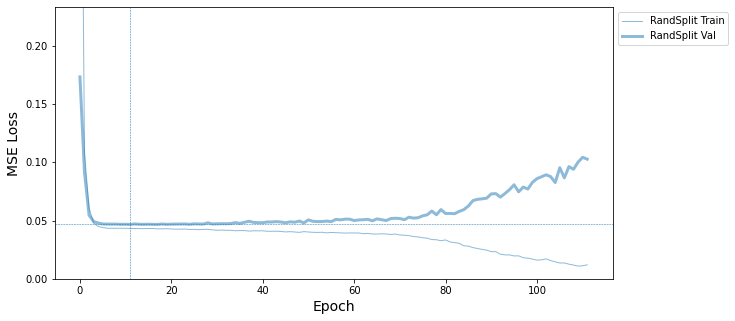

In [27]:
nets = [
    (net_randsplit,'RandSplit'),
]

sk_loss_plot(nets)

In [28]:
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay

In [29]:
#def plot_confusion_multi(models,genes,oracle,objs):
def plot_confusion_multi(models,Xs,ys,imods):
    '''Get class predictions and plot confusion matrix'''

    for sk_model,model_name in models:
        #model.eval()
        print(f"Running {model_name}")
        
        y_preds = sk_model.predict(Xs)
        
        confs = multilabel_confusion_matrix(ys, y_preds)

        # display the matrix
        #for i in range(y_preds.shape[1]):
        for i,imod in enumerate(imods):
            mats = []
            c = confs[i]
            mats.append((c,f"raw counts"))
            # get the normalized confusino matrix
            cp = np.zeros(c.shape)
            for i,row in enumerate(c):
                rowsum = sum(row)
                for j,item in enumerate(row):
                    val = item/rowsum
                    cp[i][j] = val

            mats.append((cp,f"normed counts"))
            #print(mats)
            
            f, axes = plt.subplots(1, 2, figsize=(5, 3))#, sharey='row')
            axes = list(axes)
            #axes_list = [item for sublist in axes for item in sublist]
            
            for i,(mat,title) in enumerate(mats):
                disp = ConfusionMatrixDisplay(confusion_matrix=mat)
                #disp.plot(ax=axes_list.pop(0))
                disp.plot(ax=axes.pop(0))
                disp.ax_.set_title(title)
            
            f.suptitle(f"{model_name}, iMod {imod}",fontsize=20)
            #plt.title(f"{model_name}, iMod {imod}")
            plt.tight_layout()
            # plt.show()
        
#    return dfs


In [30]:
#plot_confusion_multi(nets, Xfull_train,yfull_train,imods_filt)

In [31]:
#plot_confusion_multi(nets, Xtest,ytest,imods_filt)

In [32]:
from sklearn.metrics import classification_report

In [33]:
def alt_cls_summary(df):
    heat = alt.Chart(df).mark_rect().encode(
        x=alt.X('imod:O'),
        y=alt.Y('metric:O'),
        color='score:Q',
        tooltip=['metric:N','score:Q']
    ).properties(width=600)

    support = alt.Chart(df).mark_circle().encode(
        x=alt.X('imod:O',title='',axis=alt.Axis(labels=False)),
        color=alt.Color('support:Q', legend=None,scale=alt.Scale(scheme='greys')),
        size='support:Q',
        tooltip=['support']
    ).properties(width=600)

    return alt.vconcat(support,heat
        ).resolve_scale(color='independent'
        ).configure_concat(
            spacing=0
        )

def alt_cls_summary2(df):
    heat = alt.Chart(df).mark_rect().encode(
        x=alt.X('imod:O'),
        y=alt.Y('metric:O'),
        color='score:Q',
        tooltip=['metric:N','score:Q']
    ).properties(width=600)

    support = alt.Chart(df).mark_bar().encode(
        x=alt.X('imod:O',title='',axis=alt.Axis(labels=False)),
        color=alt.Color('support:Q', legend=None,scale=alt.Scale(scheme='greys')),
        y='support:Q',
        tooltip=['support']
    ).properties(width=600,height=50)

    return alt.vconcat(support,heat
        ).resolve_scale(color='independent'
        ).configure_concat(
            spacing=0
        )

def view_cls_report(sk_model,Xs,ys,imods):
    '''
    For a given model and set of X,y examples, save and display 
    a summary of the primary classification metrics
    '''
    # get the predictions and classification report
    y_preds = sk_model.predict(Xs)
    cls_rep = classification_report(ys, y_preds,target_names=imods,output_dict=True)
    
    # conver the dict into a df for viewing
    cls_df = pd.DataFrame.from_dict(cls_rep,orient='index')
    cls_df.index.name='imod'
    cls_df = cls_df.reset_index()
    
    # drop the micro/macro average colums
    cls_df = cls_df.drop(cls_df[~cls_df['imod'].isin(imods)].index)
    # convert to int for sorting
    cls_df['imod'] = cls_df['imod'].apply(lambda x: int(x))
    
    # melt the df for altair
    cls_melt = cls_df.melt(
        id_vars=['imod','support'],
        value_vars=['precision','recall','f1-score'],
        var_name='metric',
        value_name='score')
    
    #alt_cls_summary(cls_melt)
    display(alt_cls_summary2(cls_melt))

    return cls_df
    
    
    

In [34]:
cls_full_train_df = view_cls_report(net_randsplit,Xfull_train,yfull_train,imods_filt)
cls_test_df = view_cls_report(net_randsplit,Xtest,ytest,imods_filt)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

## train classifier with stratsplit

In [45]:
# from skmultilearn.model_selection import IterativeStratification
# k_fold = IterativeStratification(n_splits=3, order=1)
# a,b = next(k_fold.split(Xtrain_strat,ytrain_strat))

In [35]:
Xtrain_strat, ytrain_strat, Xval_strat, yval_strat = iterative_train_test_split(Xfull_train_strat, yfull_train_strat, test_size = 0.2)

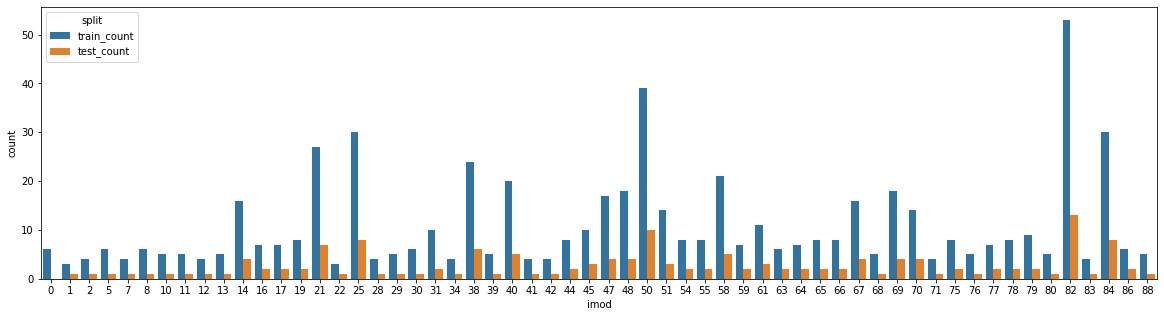

In [36]:
count_imod_train_test_labels(imods_filt,ytrain_strat,yval_strat)

In [37]:
valid_ds = Dataset(Xval_strat, yval_strat)

In [39]:
net_stratsplit = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    criterion=torch.nn.BCEWithLogitsLoss(),
    #train_split=ValidSplit(0.2),#,stratified=True),
    #train_split=k_fold.split(Xtrain_strat,ytrain_strat),
    #train_split=ValidSplit(k_fold.split(Xtrain_strat,ytrain_strat)),
    #train_split=ValidSplit(k_fold,stratified=True),
    train_split=predefined_split(valid_ds),
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=ytrain.shape[1],
    module__num_filters1=128,
    module__num_filters2=64,
    module__kernel_size1=8,
    module__kernel_size2=8,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=2000,
    lr=0.01,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=100),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.Adam,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

In [40]:
net_stratsplit.fit(Xtrain_strat, ytrain_strat)
## Hm, maybe think about switching this to cross_val_predict?
# Is skorch just using 1 val split and sometimes getting lucky?

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5545       0.5806        0.1027  0.1206
      2        0.1053       0.5806        0.0558  0.1070
      3        0.0508       0.5806        0.0451  0.0989
      4        0.0453       0.5806        0.0435  0.0820
      5        0.0440       0.5806        0.0428  0.0797
      6        0.0435       0.5806        0.0427  0.0793
      7        0.0433       0.5806        0.0426  0.0776
      8        0.0433       0.5806        0.0426  0.0775
      9        0.0434       0.5806        0.0427  0.0779
     10        0.0434       0.5806        0.0427  0.0781
     11        0.0433       0.5806        0.0427  0.0777
     12        0.0432       0.5806        0.0426  0.0778
     13        0.0431       0.5806        0.0426  0.0776
     14        0.0430       0.5806        0.0426  0.0773
     15        0.0430       0.5806        0.0426  0.0768
     16        0.0431       0.5

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 64, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=5760, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=58, bias=True)
    )
  ),
)

In [41]:
def get_class_counts(ys):
    y_sum = torch.tensor(np.zeros(ys.shape[1]))
    for ex in ys:
        y_sum += ex

    return y_sum

In [42]:
get_class_counts(ytrain_strat)

tensor([ 6.,  3.,  4.,  6.,  4.,  6.,  5.,  5.,  4.,  5., 16.,  7.,  7.,  8.,
        27.,  3., 30.,  4.,  5.,  6., 10.,  4., 24.,  5., 20.,  4.,  4.,  8.,
        10., 17., 18., 39., 14.,  8.,  8., 21.,  7., 11.,  6.,  7.,  8.,  8.,
        16.,  5., 18., 14.,  4.,  8.,  5.,  7.,  8.,  9.,  5., 53.,  4., 30.,
         6.,  5.], dtype=torch.float64)

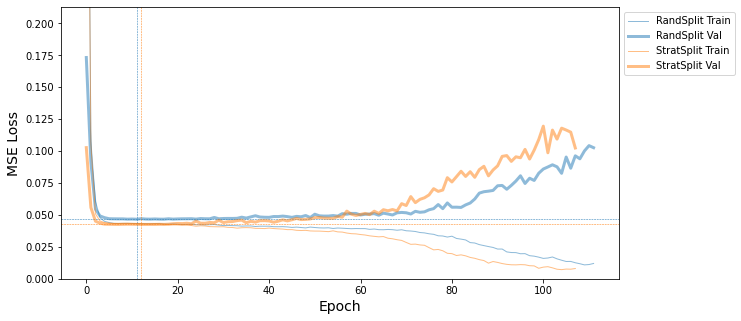

In [43]:
nets = [
    (net_randsplit,'RandSplit'),
    (net_stratsplit,'StratSplit'),
]

sk_loss_plot(nets)

In [44]:
cls_full_train_df = view_cls_report(net_stratsplit,Xtrain_strat,ytrain_strat,imods_filt)
cls_test_df = view_cls_report(net_stratsplit,Xtest_strat,ytest_strat,imods_filt)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

# What's up with this overfitting vs not overfitting thing?

In [ ]:
# rerunning wtih new valid split thing to see how many of them overfit?

In [86]:
# run a bunch of loops?
nets = []
for i in range(20):
    random.seed(1)
    print("i = ",i)
    net = NeuralNetClassifier(
        m.DNA_2CNN_2FC_Multi, # my pytorch model
        criterion=torch.nn.BCEWithLogitsLoss(),
        #train_split=ValidSplit(0.2),
        #train_split=ValidSplit(k_fold.split(Xtrain_strat,ytrain_strat)),
        train_split=predefined_split(valid_ds),
        module__seq_len=300, # pass arg to pytorch model
        module__n_tasks=ytrain.shape[1],
        module__num_filters1=128,
        module__num_filters2=64,
        module__kernel_size1=8,
        module__kernel_size2=8,
        module__conv_pool_size1=3, 
        module__conv_pool_size2=1,
        module__fc_node_num1 = 100,
        module__fc_node_num2 = 100,
#         module__dropout1 = 0.2,
#         module__dropout2 = 0.2,
        module__dropout1 = 0.0,
        module__dropout2 = 0.0, # take away all drop out??
        max_epochs=2000,
        lr=0.01,
        device=DEVICE,
         callbacks=[
             EarlyStopping(patience=200),
             #Checkpoint(load_best=True),
             #GradientNormClipping()
         ],
        optimizer=torch.optim.Adam,
        #iterator_train__shuffle=True,
        #train_split=predefined_split(valid_ds)
        #train_split=None
        verbose=0
    )
    
    net.fit(Xtrain_strat, ytrain_strat)
    
    nets.append((net,f"StratSplit Net {i}"))
    

#sk_loss_plot(nets)


i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
i =  14
i =  15
i =  16
i =  17
i =  18
i =  19


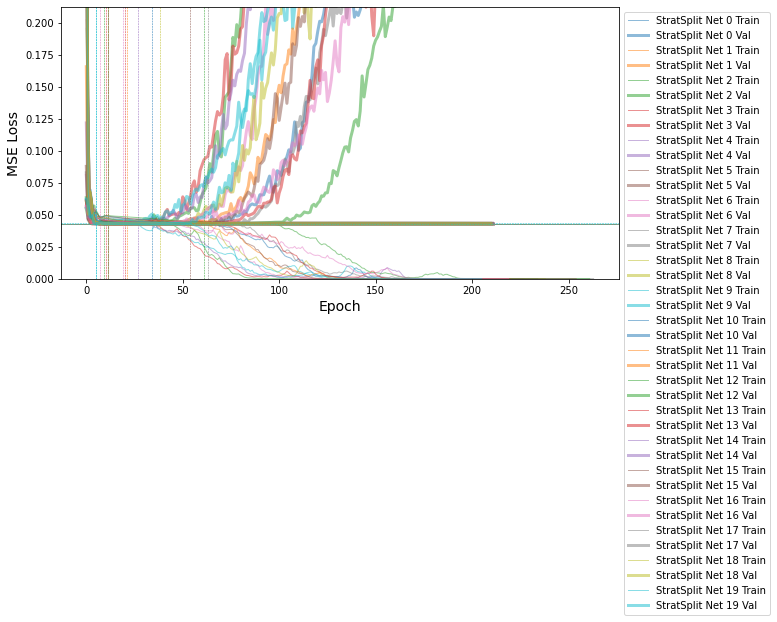

In [87]:
sk_loss_plot(nets)
## Very confused why this isn't the same everytime...

In [88]:
def sk_loss_plot2(nets,yscaler=5):
    '''
    Draw the train/val losses from a skorch net
    '''
    
    fig = plt.figure(figsize=(10,5))
    smallest_val = 999
    for i,(net,name) in enumerate(nets):
        # plot net_regr's loss trace
        train_loss = net.history[:, 'train_loss']
        valid_loss = net.history[:, 'valid_loss']
        
        plt.plot(train_loss,'-',color=f"C{i}", label=f"{name} Train",linewidth=1.0,alpha=0.5)
        plt.plot(valid_loss,'-',color=f"C{i}", label=f"{name} Val",linewidth=3.0,alpha=0.5)
        
        val_min_ep,val_min = min(enumerate(valid_loss),key = lambda t: t[1])
        plt.axhline(val_min,linestyle='--',c=f"C{i}",linewidth=0.5)
        plt.axvline(val_min_ep,linestyle='--',c=f"C{i}",linewidth=0.5)
        #plt.axhline(5,c='k')
        
        if val_min < smallest_val:
            smallest_val = val_min

    plt.ylim(0.04,0.045)
    plt.xlabel("Epoch",fontsize=14)
    plt.ylabel("MSE Loss",fontsize=14)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

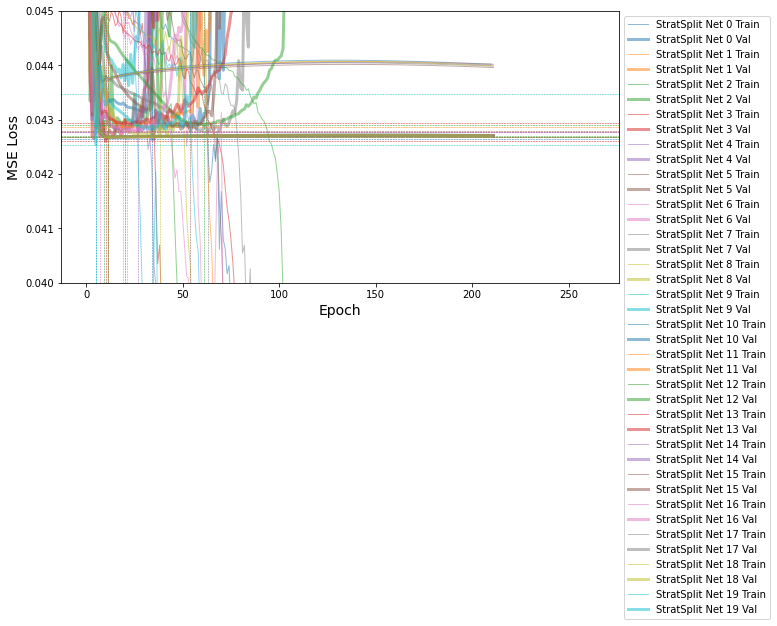

In [89]:
sk_loss_plot2(nets)


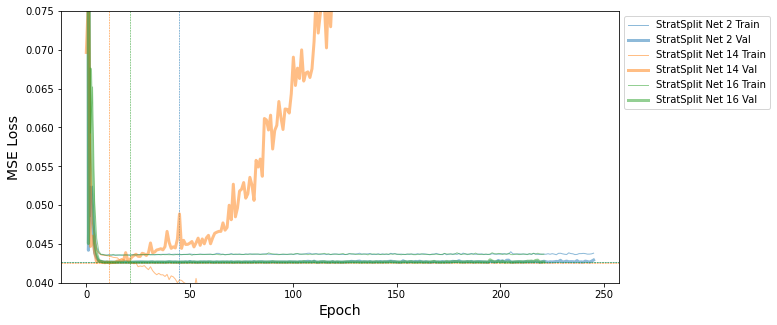

In [48]:
sk_loss_plot2([nets[2],nets[14],nets[16]])


In [69]:
nof = [2,14,16]
of = [i for i in range(20) if i not in nof]

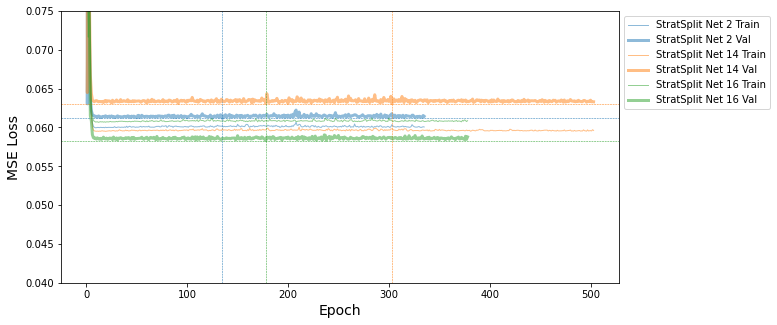

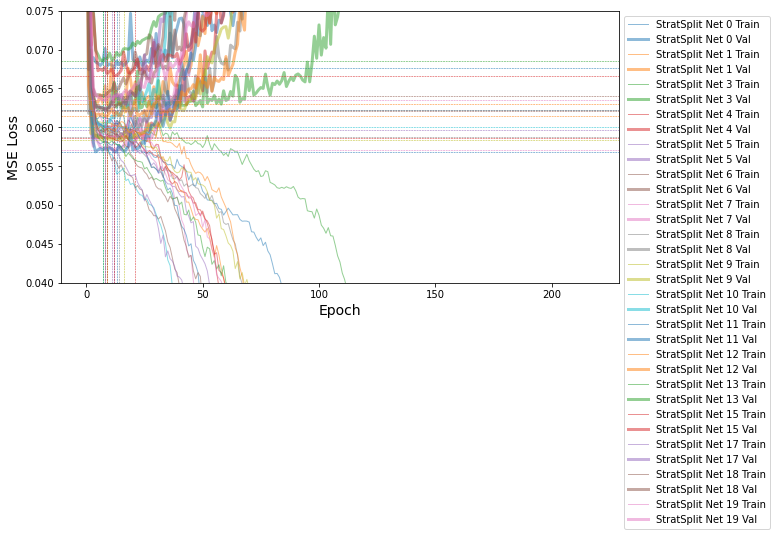

In [70]:
sk_loss_plot2([nets[i] for i in nof])
sk_loss_plot2([nets[i] for i in of])

In [60]:
# whats up with the vald splits in the nof nets?
n2 = nets[2][0]

In [70]:
n2.iterator_valid

torch.utils.data.dataloader.DataLoader

In [69]:
aa = n2.train_split(Xtrain_strat)[0]
bb = n2.train_split(Xtrain_strat)[0]

sum(sum(aa!=bb))

tensor([0, 0, 0, 0])

In [83]:
def view_valid_split(neti,X,y):
    tri, vali = neti.get_split_datasets(X,y)
    count_imod_train_test_labels(imods_filt,y[tri.indices],y[vali.indices])

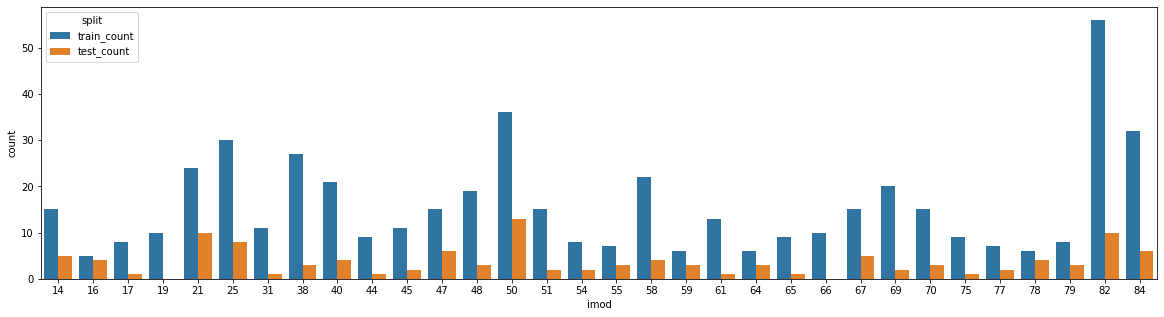

In [85]:
view_valid_split(n2,Xtrain_strat,ytrain_strat)

In [82]:
for n,name in nets:
    _ = view_cls_report(n,Xtrain_strat,ytrain_strat,imods_filt)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

In [83]:
for n,name in nets:
    _ = view_cls_report(n,Xtest_strat,ytest_strat,imods_filt)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

# wth... just do a hyperparam search anyways...?

# SKORCH search

In [190]:
from sklearn.model_selection import RandomizedSearchCV


In [212]:
net_search = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi,
    #m.DNA_2CNN_Multi,
    #m.DNA_CNN_Multi,
    #train_split=ValidSplit(0.2),
    #train_split=None,
    train_split=ValidSplit(k_fold.split(Xtrain_strat,ytrain_strat)),
    #train_split=k_fold,
    criterion=torch.nn.BCEWithLogitsLoss(),
    module__seq_len=300,
    module__n_tasks=ytrain.shape[1],
    max_epochs=2000,
    #lr=0.001,
    device=DEVICE,
    callbacks=[
         EarlyStopping(patience=100),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    verbose=0,

)


In [213]:
params = {
    'lr': [0.01, 0.001, 0.0001,],#loguniform(0.0001, 0.01)
    
    'module__num_filters1': [16,32,64,128],
    'module__num_filters2': [16,32,64,128],
    'module__kernel_size1': [4,8,16,32],
    'module__kernel_size2': [4,8,16,32],
    'module__conv_pool_size1': [2,4,8,16],
    'module__fc_node_num1': [10,50,100,500],
    'module__fc_node_num2': [10,50,100,500],
    'module__dropout1': [0.0,0.2,0.4],
    'module__dropout2': [0.0,0.2,0.4],
    'optimizer':[torch.optim.SGD, torch.optim.Adam,torch.optim.AdamW,torch.optim.RMSprop]
}

In [214]:
search = RandomizedSearchCV(
    net_search, 
    params, 
    n_iter=500, 
    #scoring='neg_mean_squared_error', 
    #scoring=['precision','recall','f1_macro'], 
    scoring=['f1_macro'], 
    refit='f1_macro',
    n_jobs=-1, 
    #cv=3,#cv, 
    #cv=k_fold.split(Xtrain_strat,ytrain_strat),
    #cv=k_fold,
    random_state=7,
    verbose=1
)

In [215]:
search.fit(Xtrain_strat,ytrain_strat)

TypeError: can't pickle generator objects

In [133]:
1-2

-1

In [106]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

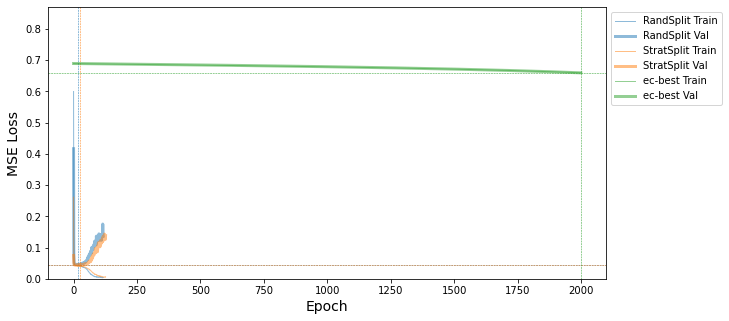

In [142]:
netss = [
    (net_randsplit,"RandSplit"),
    (net_stratsplit,"StratSplit"),
    (search.best_estimator_,'ec-best')
]

sk_loss_plot(netss,yscaler=20)

### inspect hyperparam search results

In [29]:
search.best_estimator_

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 16), stride=(1, 16), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.4, inplace=False)
      (4): Conv2d(16, 128, kernel_size=(1, 16), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.4, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=384, out_features=50, bias=True)
      (9): ReLU()
      (10): Linear(in_features=50, out_features=500, bias=True)
      (11): ReLU()
      (12): Linear(in_features=500, out_features=92, bias=True)
    )
  ),
)

In [30]:
search.best_params_

{'optimizer': torch.optim.adamw.AdamW,
 'module__num_filters2': 128,
 'module__num_filters1': 16,
 'module__kernel_size2': 16,
 'module__kernel_size1': 8,
 'module__fc_node_num2': 500,
 'module__fc_node_num1': 50,
 'module__dropout2': 0.4,
 'module__dropout1': 0.4,
 'module__conv_pool_size1': 16,
 'lr': 0.0001}

In [31]:
res_df = pd.DataFrame(search.cv_results_)
res_df['opt_name'] = res_df['param_optimizer'].apply(lambda x: x.__name__)
res_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__num_filters2,param_module__num_filters1,param_module__kernel_size2,param_module__kernel_size1,param_module__fc_node_num2,...,param_module__conv_pool_size1,param_lr,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,opt_name
0,71.967057,12.216083,0.021500,0.001165,<class 'torch.optim.rmsprop.RMSprop'>,128,64,16,4,10,...,16,0.01,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-0.000296,-0.000311,-0.000346,-0.000318,0.000021,72,RMSprop
1,163.493714,9.668032,0.018877,0.001166,<class 'torch.optim.sgd.SGD'>,32,16,32,4,50,...,2,0.0001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-0.006479,-0.007145,-0.006745,-0.006790,0.000274,92,SGD
2,41.803676,1.812703,0.021897,0.002649,<class 'torch.optim.adam.Adam'>,64,32,4,16,10,...,16,0.01,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-0.000237,-0.000253,-0.000289,-0.000260,0.000022,16,Adam
3,0.007967,0.000205,0.000000,0.000000,<class 'torch.optim.adamw.AdamW'>,32,128,32,8,100,...,16,0.01,{'optimizer': <class 'torch.optim.adamw.AdamW'...,NaN,NaN,NaN,NaN,NaN,100,AdamW
4,67.520009,29.807880,0.017562,0.000624,<class 'torch.optim.rmsprop.RMSprop'>,16,32,32,4,10,...,4,0.001,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-0.000239,-0.000255,-0.000291,-0.000262,0.000022,23,RMSprop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,46.600638,20.220994,0.017378,0.000783,<class 'torch.optim.rmsprop.RMSprop'>,16,16,8,32,50,...,4,0.01,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-0.000296,-0.000308,-0.000346,-0.000317,0.000021,63,RMSprop
96,74.883984,12.679929,0.018746,0.001701,<class 'torch.optim.adamw.AdamW'>,128,64,8,16,10,...,8,0.0001,{'optimizer': <class 'torch.optim.adamw.AdamW'...,-0.000429,-0.000292,-0.000362,-0.000361,0.000056,78,AdamW
97,123.845607,46.760401,0.020805,0.000315,<class 'torch.optim.adamw.AdamW'>,128,16,16,16,10,...,8,0.0001,{'optimizer': <class 'torch.optim.adamw.AdamW'...,-0.000242,-0.000269,-0.000297,-0.000270,0.000022,42,AdamW
98,178.359135,2.837735,0.022018,0.003054,<class 'torch.optim.sgd.SGD'>,128,128,8,16,10,...,16,0.0001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-0.030090,-0.036958,-0.036385,-0.034478,0.003112,96,SGD


In [32]:
sm_res_df = res_df[[
    "rank_test_score",
    "mean_test_score",
    "param_module__num_filters1",
    "param_module__num_filters2",
    "param_module__kernel_size1",
    "param_module__kernel_size2",
    "param_lr",
    "param_module__fc_node_num1",
    "param_module__fc_node_num2",
    "opt_name"]]

In [33]:
sm_res_df

,rank_test_score,mean_test_score,param_module__num_filters1,param_module__num_filters2,param_module__kernel_size1,param_module__kernel_size2,param_lr,param_module__fc_node_num1,param_module__fc_node_num2,opt_name
0,72,-0.000318,64,128,4,16,0.01,500,10,RMSprop
1,92,-0.006790,16,32,4,32,0.0001,100,50,SGD
2,16,-0.000260,32,64,16,4,0.01,10,10,Adam
3,100,NaN,128,32,8,32,0.01,100,100,AdamW
4,23,-0.000262,32,16,4,32,0.001,50,10,RMSprop
...,...,...,...,...,...,...,...,...,...,...
95,63,-0.000317,16,16,32,8,0.01,50,50,RMSprop
96,78,-0.000361,64,128,16,8,0.0001,50,10,AdamW
97,42,-0.000270,16,128,16,16,0.0001,500,10,AdamW
98,96,-0.034478,128,128,16,8,0.0001,50,10,SGD


In [34]:
alt.Chart(sm_res_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    #shape="param_module__kernel_size1:N"
    
).interactive()

alt.Chart(...)

In [35]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__kernel_size1:O',title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='param_module__num_filters1:N',
#     detail='model_desc:N',
    shape="opt_name:N",
    tooltip=["rank_test_score:O","param_module__num_filters1:N","param_module__kernel_size1:N","param_lr:N","param_module__fc_node_num1:N"]
    
).interactive()

alt.Chart(...)

In [37]:
alt.Chart(sm_res_df).mark_boxplot(extent='min-max').encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    #color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [38]:
alt.Chart(sm_res_df[~sm_res_df['opt_name'].isin(['SGD'])]).mark_boxplot(extent='min-max').encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    #color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [39]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('rank_test_score:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__kernel_size1:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [41]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__fc_node_num1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('rank_test_score:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__fc_node_num2:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [42]:
res_df.to_csv('ec_iMod_out/hyper100_1.tsv',sep='\t',index=False)

## try cros_val_predict

In [ ]:
# {'optimizer': torch.optim.adam.Adam,
#  'module__num_filters2': 128,
#  'module__num_filters1': 128,
#  'module__kernel_size2': 16,
#  'module__kernel_size1': 4,
#  'module__fc_node_num1': 500,
#  'module__dropout2': 0.4,
#  'module__dropout1': 0.0,
#  'module__conv_pool_size1': 4,
#  'lr': 0.01}

In [74]:
net_cvp = NeuralNetClassifier(
        m.DNA_2CNN_2FC_Multi, # my pytorch model
        criterion=torch.nn.BCEWithLogitsLoss(),
        #train_split=ValidSplit(0.2),
        #train_split=ValidSplit(k_fold.split(Xtrain_strat,ytrain_strat)),
        train_split=None,
        module__seq_len=300, # pass arg to pytorch model
        module__n_tasks=ytrain.shape[1],
        module__num_filters1=128,
        module__num_filters2=64,
        module__kernel_size1=8,
        module__kernel_size2=8,
        module__conv_pool_size1=3, 
        module__conv_pool_size2=1,
        module__fc_node_num1 = 100,
        module__fc_node_num2 = 100,
        module__dropout1 = 0.2,
        module__dropout2 = 0.2,
        max_epochs=2000,
        lr=0.01,
        device=DEVICE,
         callbacks=[
             EarlyStopping(patience=200,monitor='train_loss'),
             # suggested monitoring train loss when i want to do gridsearchcv with early stop?
             # https://github.com/skorch-dev/skorch/issues/837
             #Checkpoint(load_best=True),
             GradientNormClipping()
         ],
        optimizer=torch.optim.Adam,
        iterator_train__shuffle=True,
        #train_split=predefined_split(valid_ds)
        #train_split=None,
        verbose=1
    )

In [75]:
from sklearn.model_selection import cross_val_predict

In [76]:
y_pred = cross_val_predict(net_cvp, Xtrain_strat, ytrain_strat, cv=5)

# these instructions for using skorch with cross_val_predict don't work
# https://skorch.readthedocs.io/en/latest/user/dataset.html?highlight=fold#validsplit

# when train_split=None, then "valid loss" is not in history
# when train_split is left default, it says StratifiedCV needs a suitable y

  epoch    train_loss     dur
-------  ------------  ------
      1        0.5955  0.0902
      2        0.1069  0.0893
      3        0.0700  0.0672
      4        0.0555  0.0666
      5        0.0519  0.0659
      6        0.0500  0.0603
      7        0.0489  0.0582
      8        0.0483  0.0583
      9        0.0483  0.0579
     10        0.0482  0.0589
     11        0.0484  0.0579
     12        0.0480  0.0546
     13        0.0482  0.0576
     14        0.0481  0.0568
     15        0.0482  0.0570
     16        0.0481  0.0566
     17        0.0478  0.0570
     18        0.0479  0.0573
     19        0.0480  0.0577
     20        0.0482  0.0584
     21        0.0480  0.0583
     22        0.0474  0.0579
     23        0.0474  0.0584
     24        0.0475  0.0580
     25        0.0473  0.0587
     26        0.0475  0.0579
     27        0.0471  0.0580
     28        0.0468  0.0579
     29        0.0467  0.0580
     30        0.0475  0.0579
     31        0.0467  0.0579
     32   

    241        0.0040  0.0555
    242        0.0042  0.0554
    243        0.0048  0.0555
    244        0.0046  0.0555
    245        0.0056  0.0559
    246        0.0044  0.0558
    247        0.0041  0.0557
    248        0.0039  0.0556
    249        0.0042  0.0562
    250        0.0039  0.0563
    251        0.0050  0.0559
    252        0.0035  0.0559
    253        0.0051  0.0562
    254        0.0055  0.0564
    255        0.0051  0.0559
    256        0.0049  0.0558
    257        0.0048  0.0556
    258        0.0043  0.0556
    259        0.0032  0.0557
    260        0.0041  0.0557
    261        0.0041  0.0561
    262        0.0053  0.0556
    263        0.0037  0.0556
    264        0.0036  0.0555
    265        0.0048  0.0558
    266        0.0035  0.0559
    267        0.0043  0.0559
    268        0.0038  0.0556
    269        0.0039  0.0556
    270        0.0046  0.0557
    271        0.0048  0.0559
    272        0.0034  0.0561
    273        0.0041  0.0560
    274   

    512        0.0060  0.0582
    513        0.0043  0.0582
    514        0.0047  0.0585
    515        0.0046  0.0586
    516        0.0044  0.0578
    517        0.0053  0.0577
    518        0.0054  0.0579
    519        0.0048  0.0578
    520        0.0041  0.0576
    521        0.0032  0.0577
    522        0.0041  0.0578
    523        0.0040  0.0577
    524        0.0043  0.0577
    525        0.0036  0.0575
    526        0.0025  0.0576
    527        0.0043  0.0575
    528        0.0034  0.0576
    529        0.0039  0.0573
    530        0.0046  0.0574
    531        0.0039  0.0578
    532        0.0045  0.0575
    533        0.0029  0.0576
    534        0.0039  0.0578
    535        0.0039  0.0578
    536        0.0041  0.0576
    537        0.0043  0.0579
    538        0.0040  0.0577
    539        0.0043  0.0580
    540        0.0049  0.0576
    541        0.0033  0.0578
    542        0.0047  0.0575
    543        0.0041  0.0576
    544        0.0037  0.0579
    545   

      2        0.1280  0.0578
      3        0.0697  0.0594
      4        0.0581  0.0584
      5        0.0525  0.0580
      6        0.0507  0.0581
      7        0.0489  0.0585
      8        0.0486  0.0586
      9        0.0484  0.0581
     10        0.0486  0.0574
     11        0.0481  0.0575
     12        0.0482  0.0577
     13        0.0481  0.0576
     14        0.0482  0.0573
     15        0.0485  0.0574
     16        0.0485  0.0574
     17        0.0478  0.0576
     18        0.0482  0.0569
     19        0.0481  0.0574
     20        0.0480  0.0579
     21        0.0478  0.0576
     22        0.0475  0.0566
     23        0.0476  0.0555
     24        0.0475  0.0558
     25        0.0473  0.0559
     26        0.0474  0.0559
     27        0.0473  0.0555
     28        0.0472  0.0555
     29        0.0471  0.0557
     30        0.0468  0.0565
     31        0.0470  0.0551
     32        0.0469  0.0552
     33        0.0466  0.0551
     34        0.0467  0.0555
     35   

    242        0.0029  0.0555
    243        0.0029  0.0556
    244        0.0027  0.0556
    245        0.0029  0.0557
    246        0.0034  0.0575
    247        0.0027  0.0585
    248        0.0036  0.0589
    249        0.0029  0.0586
    250        0.0045  0.0586
    251        0.0036  0.0584
    252        0.0033  0.0584
    253        0.0038  0.0585
    254        0.0037  0.0588
    255        0.0043  0.0583
    256        0.0034  0.0582
    257        0.0040  0.0584
    258        0.0032  0.0585
    259        0.0036  0.0592
    260        0.0036  0.0593
    261        0.0031  0.0587
    262        0.0031  0.0586
    263        0.0027  0.0583
    264        0.0032  0.0579
    265        0.0025  0.0589
    266        0.0033  0.0585
    267        0.0037  0.0584
    268        0.0032  0.0582
    269        0.0038  0.0585
    270        0.0032  0.0580
    271        0.0047  0.0579
    272        0.0038  0.0571
    273        0.0037  0.0571
    274        0.0026  0.0579
    275   

    514        0.0042  0.0586
    515        0.0042  0.0590
    516        0.0031  0.0592
    517        0.0031  0.0587
    518        0.0047  0.0586
    519        0.0042  0.0583
    520        0.0038  0.0592
    521        0.0042  0.0591
    522        0.0033  0.0586
    523        0.0045  0.0587
    524        0.0041  0.0585
    525        0.0047  0.0587
    526        0.0037  0.0594
    527        0.0053  0.0584
    528        0.0041  0.0586
    529        0.0057  0.0587
    530        0.0039  0.0585
    531        0.0032  0.0586
    532        0.0023  0.0586
    533        0.0026  0.0587
    534        0.0026  0.0583
    535        0.0034  0.0589
    536        0.0038  0.0586
    537        0.0031  0.0590
    538        0.0040  0.0587
    539        0.0038  0.0584
    540        0.0027  0.0589
    541        0.0038  0.0585
    542        0.0063  0.0586
    543        0.0039  0.0587
    544        0.0051  0.0585
    545        0.0041  0.0582
    546        0.0045  0.0584
    547   

     89        0.0056  0.0551
     90        0.0052  0.0551
     91        0.0049  0.0548
     92        0.0048  0.0550
     93        0.0050  0.0545
     94        0.0044  0.0563
     95        0.0047  0.0550
     96        0.0043  0.0551
     97        0.0035  0.0552
     98        0.0034  0.0552
     99        0.0031  0.0551
    100        0.0030  0.0551
    101        0.0037  0.0552
    102        0.0028  0.0551
    103        0.0031  0.0551
    104        0.0028  0.0552
    105        0.0029  0.0551
    106        0.0033  0.0549
    107        0.0039  0.0550
    108        0.0035  0.0552
    109        0.0042  0.0556
    110        0.0036  0.0553
    111        0.0048  0.0552
    112        0.0035  0.0551
    113        0.0039  0.0551
    114        0.0031  0.0551
    115        0.0031  0.0551
    116        0.0037  0.0552
    117        0.0030  0.0546
    118        0.0026  0.0575
    119        0.0036  0.0574
    120        0.0031  0.0564
    121        0.0031  0.0561
    122   

    357        0.0020  0.0571
    358        0.0035  0.0572
    359        0.0029  0.0571
    360        0.0024  0.0572
    361        0.0021  0.0584
    362        0.0020  0.0577
    363        0.0022  0.0575
    364        0.0028  0.0577
    365        0.0036  0.0577
    366        0.0032  0.0560
    367        0.0043  0.0559
    368        0.0022  0.0560
    369        0.0033  0.0563
    370        0.0038  0.0560
    371        0.0020  0.0558
    372        0.0036  0.0557
    373        0.0049  0.0556
    374        0.0041  0.0558
    375        0.0044  0.0561
    376        0.0064  0.0560
    377        0.0059  0.0559
    378        0.0059  0.0560
    379        0.0042  0.0561
    380        0.0051  0.0558
    381        0.0052  0.0560
    382        0.0042  0.0554
    383        0.0030  0.0555
    384        0.0035  0.0554
    385        0.0041  0.0564
    386        0.0036  0.0562
    387        0.0028  0.0562
    388        0.0035  0.0559
    389        0.0036  0.0559
    390   

    190        0.0028  0.0550
    191        0.0032  0.0549
    192        0.0040  0.0550
    193        0.0034  0.0549
    194        0.0035  0.0549
    195        0.0041  0.0547
    196        0.0037  0.0547
    197        0.0040  0.0549
    198        0.0045  0.0548
    199        0.0045  0.0548
    200        0.0046  0.0549
    201        0.0044  0.0547
    202        0.0046  0.0546
    203        0.0043  0.0546
    204        0.0040  0.0547
    205        0.0040  0.0547
    206        0.0052  0.0549
    207        0.0050  0.0546
    208        0.0041  0.0548
    209        0.0034  0.0548
    210        0.0032  0.0550
    211        0.0031  0.0552
    212        0.0037  0.0550
    213        0.0037  0.0550
    214        0.0037  0.0550
    215        0.0032  0.0549
    216        0.0038  0.0550
    217        0.0042  0.0550
    218        0.0036  0.0549
    219        0.0032  0.0549
    220        0.0030  0.0548
    221        0.0039  0.0547
    222        0.0038  0.0550
    223   

    461        0.0025  0.0549
    462        0.0020  0.0549
    463        0.0019  0.0547
    464        0.0024  0.0548
    465        0.0017  0.0552
    466        0.0022  0.0554
    467        0.0028  0.0553
    468        0.0037  0.0551
    469        0.0029  0.0551
    470        0.0032  0.0550
    471        0.0034  0.0550
    472        0.0052  0.0550
    473        0.0050  0.0551
    474        0.0030  0.0551
    475        0.0040  0.0551
    476        0.0043  0.0550
    477        0.0029  0.0550
    478        0.0028  0.0549
    479        0.0032  0.0546
    480        0.0035  0.0548
    481        0.0042  0.0548
    482        0.0025  0.0549
    483        0.0037  0.0550
    484        0.0036  0.0550
    485        0.0038  0.0550
    486        0.0040  0.0548
    487        0.0035  0.0550
    488        0.0036  0.0550
    489        0.0021  0.0553
    490        0.0033  0.0552
    491        0.0029  0.0550
    492        0.0029  0.0551
    493        0.0032  0.0553
    494   

    187        0.0349  0.0550
    188        0.0349  0.0550
    189        0.0349  0.0551
    190        0.0349  0.0550
    191        0.0351  0.0551
    192        0.0349  0.0551
    193        0.0351  0.0552
    194        0.0350  0.0551
    195        0.0350  0.0549
    196        0.0350  0.0550
    197        0.0349  0.0556
    198        0.0348  0.0554
    199        0.0350  0.0557
    200        0.0350  0.0553
    201        0.0349  0.0550
    202        0.0349  0.0550
    203        0.0349  0.0549
    204        0.0349  0.0548
    205        0.0349  0.0549
    206        0.0349  0.0550
    207        0.0350  0.0549
    208        0.0349  0.0547
    209        0.0349  0.0551
    210        0.0349  0.0550
    211        0.0349  0.0552
    212        0.0348  0.0551
    213        0.0348  0.0549
    214        0.0349  0.0550
    215        0.0348  0.0548
    216        0.0349  0.0548
    217        0.0349  0.0548
Stopping since train_loss has not improved in the last 200 epochs.


In [77]:
netts = [
    #(search.best_estimator_,'ec-best_oldarch'),
    (net_cvp, 'manual cvp?')
]

sk_loss_plot(netts)

# errors because cross_val_predict doesn't actually train the model...?

TypeError: 'NoneType' object is not subscriptable

<Figure size 720x360 with 0 Axes>

In [78]:
net_cvp

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class 'models.DNA_2CNN_2FC_Multi'>,
  module__conv_pool_size1=3,
  module__conv_pool_size2=1,
  module__dropout1=0.2,
  module__dropout2=0.2,
  module__fc_node_num1=100,
  module__fc_node_num2=100,
  module__kernel_size1=8,
  module__kernel_size2=8,
  module__n_tasks=58,
  module__num_filters1=128,
  module__num_filters2=64,
  module__seq_len=300,
)

In [79]:
y_pred

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [80]:
def view_cls_report2(yt,yp,imods):
    '''
    For a given model and set of X,y examples, save and display 
    a summary of the primary classification metrics
    '''
    # get the classification report
    cls_rep = classification_report(yt, yp,target_names=imods,output_dict=True)
    
    # conver the dict into a df for viewing
    cls_df = pd.DataFrame.from_dict(cls_rep,orient='index')
    cls_df.index.name='imod'
    cls_df = cls_df.reset_index()
    
    # drop the micro/macro average colums
    cls_df = cls_df.drop(cls_df[~cls_df['imod'].isin(imods)].index)
    # convert to int for sorting
    cls_df['imod'] = cls_df['imod'].apply(lambda x: int(x))
    
    # melt the df for altair
    cls_melt = cls_df.melt(
        id_vars=['imod','support'],
        value_vars=['precision','recall','f1-score'],
        var_name='metric',
        value_name='score')
    
    #alt_cls_summary(cls_melt)
    display(alt_cls_summary2(cls_melt))

    return cls_df

In [81]:
# from cross_val_predict preds
view_cls_report2(ytrain_strat,y_pred,imods_filt)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

,imod,precision,recall,f1-score,support
0,0,0.0,0.0,0.0,6
1,1,0.0,0.0,0.0,3
2,2,0.0,0.0,0.0,4
3,5,0.0,0.0,0.0,6
4,7,0.0,0.0,0.0,4
5,8,0.0,0.0,0.0,6
6,10,0.0,0.0,0.0,5
7,11,0.0,0.0,0.0,5
8,12,0.0,0.0,0.0,4
9,13,0.0,0.0,0.0,5


YTRUE torch.Size([1362, 92])
**** ave r2:     -0.0005887257365900982
**** r2 overall: -0.0005887258745234803
YTRUE torch.Size([341, 92])
**** ave r2:     -0.0030626685740936716
**** r2 overall: -0.003062669608321528


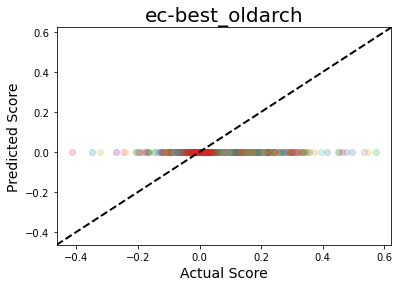

NotInitializedError: This NeuralNetRegressor instance is not initialized yet. Call 'initialize' or 'fit' with appropriate arguments before using this method.

In [60]:
view_preds(nets,make_legend=False)

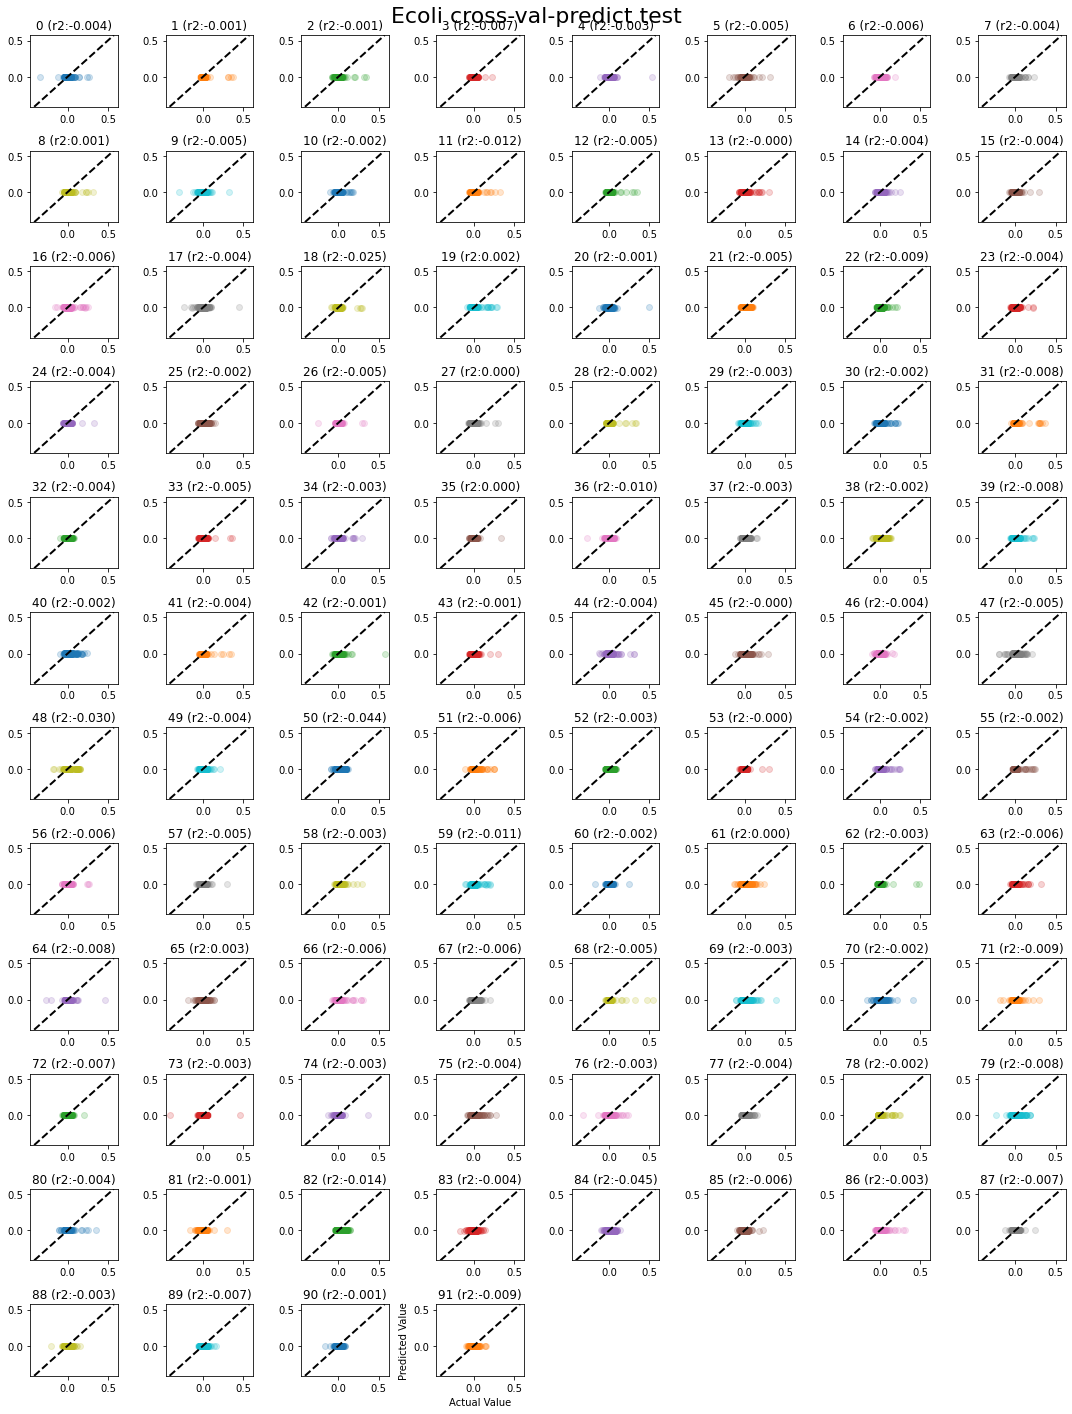

In [61]:
view_multi_parity("Ecoli cross-val-predict test", 
    y, 
    y_pred,
    rigid=True)

# Next ideas
* Retry with data aug 
* gradient clipping


# NOTE: 
--> using "load_best" = True seems to work now?? Stops on the final one